In this notebook, we study an aviation accidents dataset from [kaggle]('https://www.kaggle.com/khsamaha/aviation-accident-database-synopses'). 

In [1]:
import opendatasets as od
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


## 1- Downloading the dataset

In [2]:
ds_url =  'https://www.kaggle.com/khsamaha/aviation-accident-database-synopses'
od.download_kaggle_dataset(ds_url,'.\data')

ds_filepath = '.\\data\\aviation-accident-database-synopses\\AviationData.csv'
states_filepath = '.\\data\\aviation-accident-database-synopses\\USState_Codes.csv'

aviation_ds = pd.read_csv(ds_filepath, encoding='ISO-8859-1')
states_ds = pd.read_csv(states_filepath, encoding='ISO-8859-1')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
  0%|          | 0.00/4.04M [00:00<?, ?B/s]Downloading aviation-accident-database-synopses.zip to .\data\aviation-accident-database-synopses
100%|██████████| 4.04M/4.04M [00:01<00:00, 4.06MB/s]



We downloaded two csv files. The `states_ds` dataset contains a list of US states and theit two-letters abbreviations. The main dataset is `aviation_ds`. Let's explore it !

In [3]:
print('Columns :')
print(aviation_ds.columns)
print('\n')
aviation_ds.info()

Columns :
Index(['Event.Id', 'Investigation.Type', 'Accident.Number', 'Event.Date',
       'LOCATION', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85976 entries, 0 to 85975
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                85976 non-null  object 
 1   Investigation.Type      85963 non-null  object 
 2   Accident.Number         85976 non-

This dataset contains more than 85k records of aviation incidents/accidents. Each event is described using multiple parameters. Let's check the first column of interest. 

In [4]:
aviation_ds['Investigation.Type'].unique()

array(['Accident', 'Incident', nan], dtype=object)

The investigations are grouped into two (or three if we consider the 'nan' class). **Incident** refer to an unexpected event, that causes safety concerns. **Accidents** are incidents that invlove injuries or deaths.
  
    
For every event, a date is provided through `Event.date` column. Let's convert it to date/time data type :

In [5]:
aviation_ds['Event.Date'] = pd.to_datetime(aviation_ds['Event.Date'])
aviation_ds['Event.Date'].describe()

ipykernel_launcher:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                   85976
unique                  14117
top       2000-07-08 00:00:00
freq                       25
first     1948-10-24 00:00:00
last      2021-02-16 00:00:00
Name: Event.Date, dtype: object

The first recorded event happened on 1948, so more than 73 years ago. Let's check which weekdays and months are more represented in the data.

<AxesSubplot:xlabel='Event.Month', ylabel='Count'>

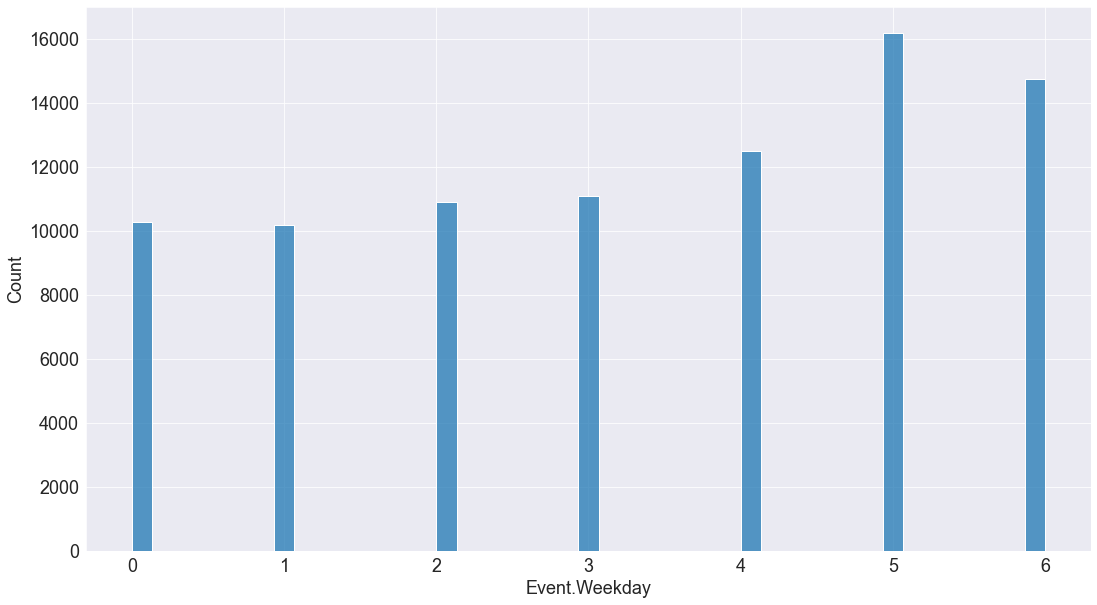

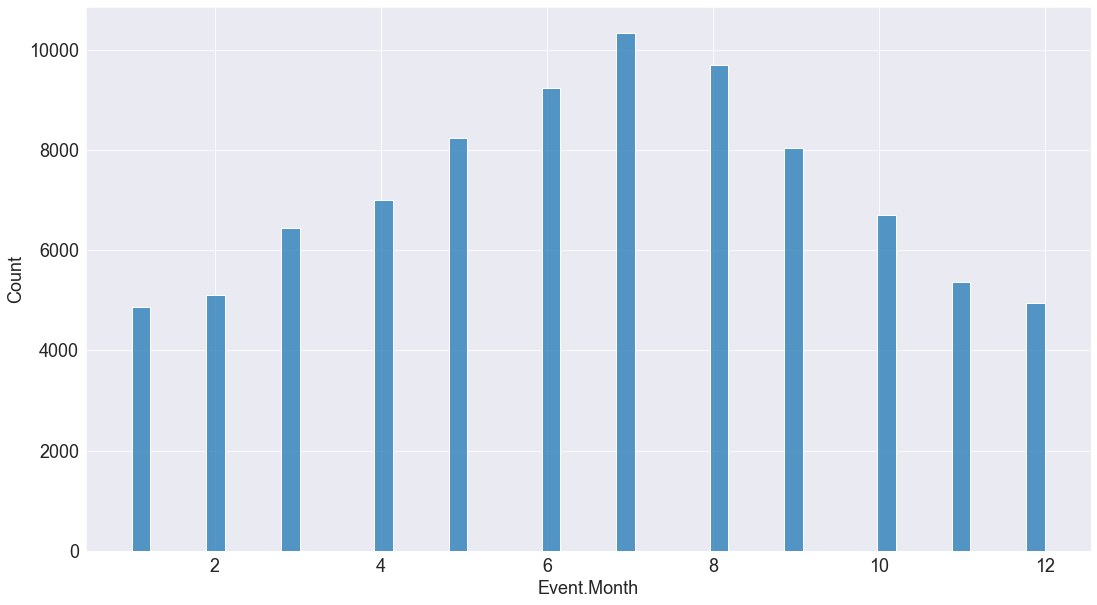

In [6]:
aviation_ds['Event.Weekday']=aviation_ds['Event.Date'].dt.weekday # 0 is monday, 6 is sunday
aviation_ds['Event.Month']=aviation_ds['Event.Date'].dt.month # 
sns.histplot(x ='Event.Weekday', data = aviation_ds, stat='count', )
plt.figure()
sns.histplot(x ='Event.Month', data = aviation_ds, stat='count')

The first histogram shows that events happen more often on *weekends*. This is expected due to the large number of amateur pilots flying only on weekends. We will see later the relationship between the type of aircraft and the probablity of accidents/incidents.  
The second plot shows that events are more likely to happen during summertime in the northern hemisphere. This is probably due to the largest aviation activity in this region (north America, Europe and Asia). Another reason would be that our dataset has more entries from the USA, as we will see later.  
Let's consider the columns `LOCATION` and `Country`. First we have to fix a small problem about datatype:

In [7]:
aviation_ds.dtypes


Event.Id                          object
Investigation.Type                object
Accident.Number                   object
Event.Date                datetime64[ns]
LOCATION                          object
Country                           object
Latitude                         float64
Longitude                        float64
Airport.Code                      object
Airport.Name                      object
Injury.Severity                   object
Aircraft.damage                   object
Aircraft.Category                 object
Registration.Number               object
Make                              object
Model                             object
Amateur.Built                     object
Number.of.Engines                float64
Engine.Type                       object
FAR.Description                   object
Schedule                          object
Purpose.of.flight                 object
Air.carrier                       object
Total.Fatal.Injuries             float64
Total.Serious.In

We need the `Country` column to be of text or string datatype.

In [8]:
aviation_ds['Country']=aviation_ds['Country'].astype(str)
x = aviation_ds.groupby('Country')['Event.Id'].count().sort_values(ascending=False).head(10)
print(x)

Country
United States     80132
nan                 507
Canada              318
Mexico              309
Brazil              305
United Kingdom      282
Australia           277
France              209
Bahamas             208
Germany             194
Name: Event.Id, dtype: int64


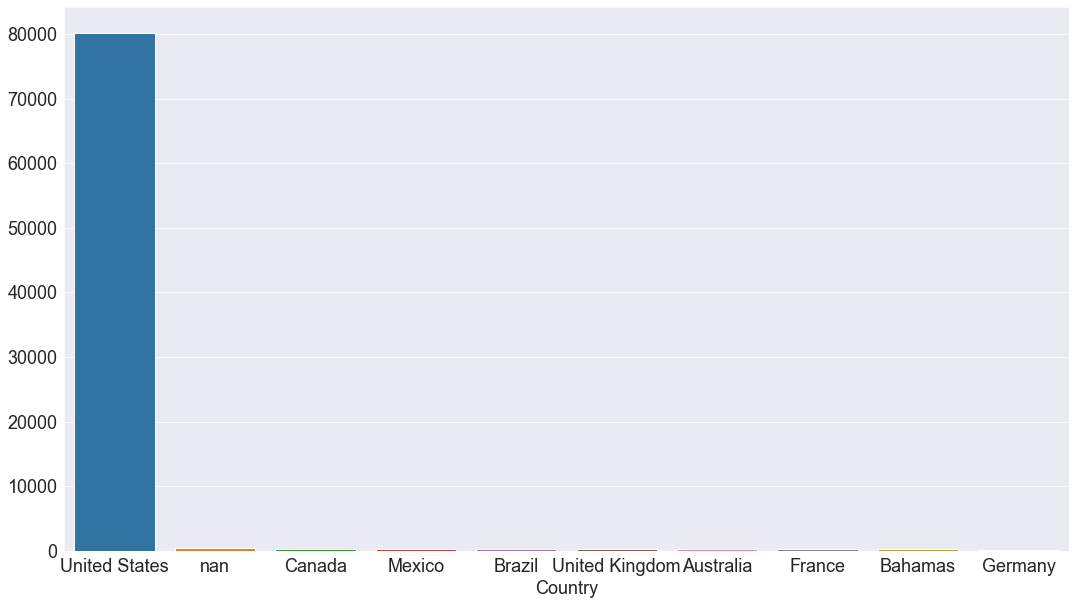

In [9]:
sns.barplot(x = x.index, y = x.values);

Most of the dataset describes events that happend in the USA.  
Using the `LOCATION` column, we can extract the states (when the location is in the USA):

In [10]:

def get_state(text):
    return str(text)[-2:]

aviation_ds['Event.State'] = aviation_ds[aviation_ds['Country']=='United States']['LOCATION'].apply(get_state)
aviation_ds['Event.State'].unique() 

array(['WI', 'CB', 'AK', 'FL', 'WY', 'MO', 'VA', 'AZ', 'UT', 'SC', 'CA',
       'ID', 'MI', 'MA', 'LA', 'CO', 'TN', 'IA', 'WA', 'TX', 'MT', 'NC',
       'OR', 'GA', 'NV', 'AL', 'NY', 'OK', 'AR', 'NH', 'MN', 'PA', 'MS',
       'IL', 'NE', 'ME', 'SD', 'IN', 'KS', 'DE', 'NJ', 'KY', 'OH', 'ND',
       'HI', 'NM', 'MD', 'CT', 'RI', nan, 'VT', 'PR', 'O,', 'an', 'WV',
       'UN', 'GM', 'VI', 'MP', 'AO', 'PO', 'GU', 'MH', 'FN', 'DC', 'ON'],
      dtype=object)

In this section, we consider the `Injury.Severity` column.

In [11]:
aviation_ds['Injury.Severity'].unique()

array(['Fatal', 'Minor', 'Non-Fatal', 'Siruose', nan, 'Unavailable',
       'Incident', 'Fatal(1)', 'Fatal(2)', 'Fatal(8)', 'Fatal(5)',
       'Fatal(3)', 'Fatal(4)', 'Fatal(9)', 'Fatal(176)', 'Fatal(7)',
       'Fatal(29)', 'Fatal(6)', 'Fatal(10)', 'Fatal(11)', 'Fatal(14)',
       'Fatal(41)', 'Fatal(157)', 'Fatal(188)', 'Fatal(112)', 'Fatal(71)',
       'Fatal(12)', 'Fatal(39)', 'Fatal(16)', 'Fatal(66)', 'Fatal(62)',
       'Fatal(23)', 'Fatal(224)', 'Fatal(150)', 'Fatal(43)', 'Fatal(162)',
       'Fatal(58)', 'Fatal(295)', 'Fatal(239)', 'Fatal(33)', 'Fatal(50)',
       'Fatal(21)', 'Fatal(19)', 'Fatal(153)', 'Fatal(127)', 'Fatal(28)',
       'Fatal(77)', 'Fatal(42)', 'Fatal(158)', 'Fatal(103)', 'Fatal(89)',
       'Fatal(90)', 'Fatal(152)', 'Fatal(228)', 'Fatal(17)', 'Fatal(13)',
       'Fatal(24)', 'Fatal(88)', 'Fatal(65)', 'Fatal(154)', 'Fatal(30)',
       'Fatal(20)', 'Fatal(40)', 'Fatal(57)', 'Fatal(199)', 'Fatal(114)',
       'Fatal(102)', 'Fatal(96)', 'Fatal(49)', 'Fatal(124)'

There's already a column detailing the number of fatal injuries, so the number between bracket is not necessary. 

In [12]:
aviation_ds['Total.Fatal.Injuries']

0        2.0
1        4.0
2        0.0
3        0.0
4        0.0
        ... 
85971    1.0
85972    2.0
85973    3.0
85974    4.0
85975    2.0
Name: Total.Fatal.Injuries, Length: 85976, dtype: float64

We can fix this by applying a function that removes the brackets and the number. We will replace `Siruose` by 'Serious' 

In [13]:
def remove_fatal(text):
    if 'Fatal(' in text:
        return 'Fatal'
    elif text == 'Siruose':
        return 'Serious'
    else:
        return text
aviation_ds['Injury.Severity'] = aviation_ds['Injury.Severity'].astype(str)
aviation_ds['Injury.Severity'] = aviation_ds['Injury.Severity'].apply(remove_fatal)
aviation_ds['Injury.Severity'] .unique()

array(['Fatal', 'Minor', 'Non-Fatal', 'Serious', 'nan', 'Unavailable',
       'Incident'], dtype=object)

Now we can drow a plot of this information :

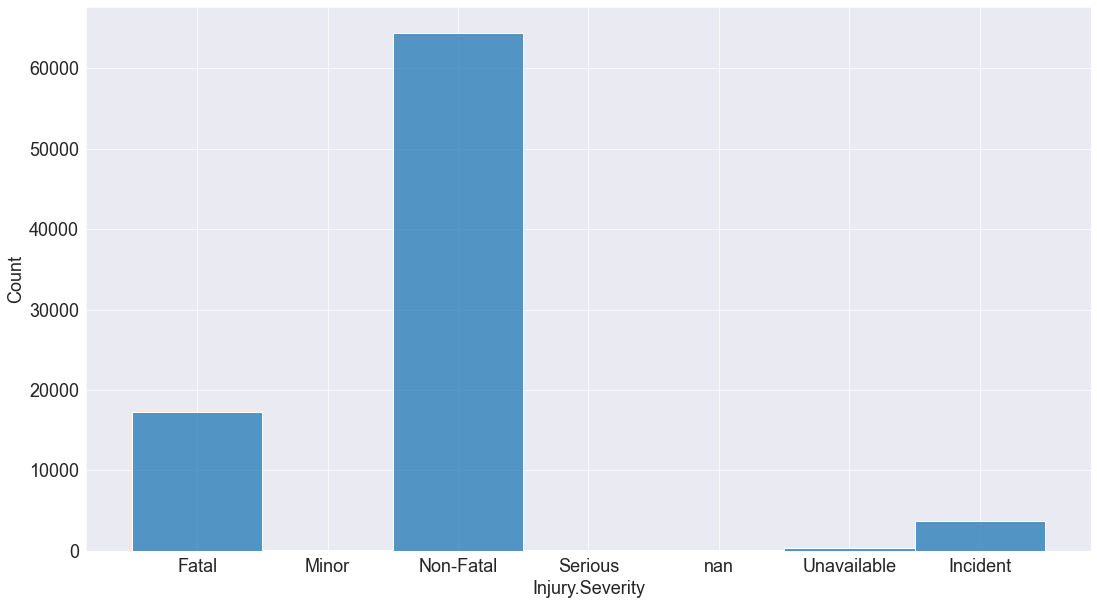

In [14]:
sns.histplot(x ='Injury.Severity', data = aviation_ds );

Now we display the column `Aircraft.damage`

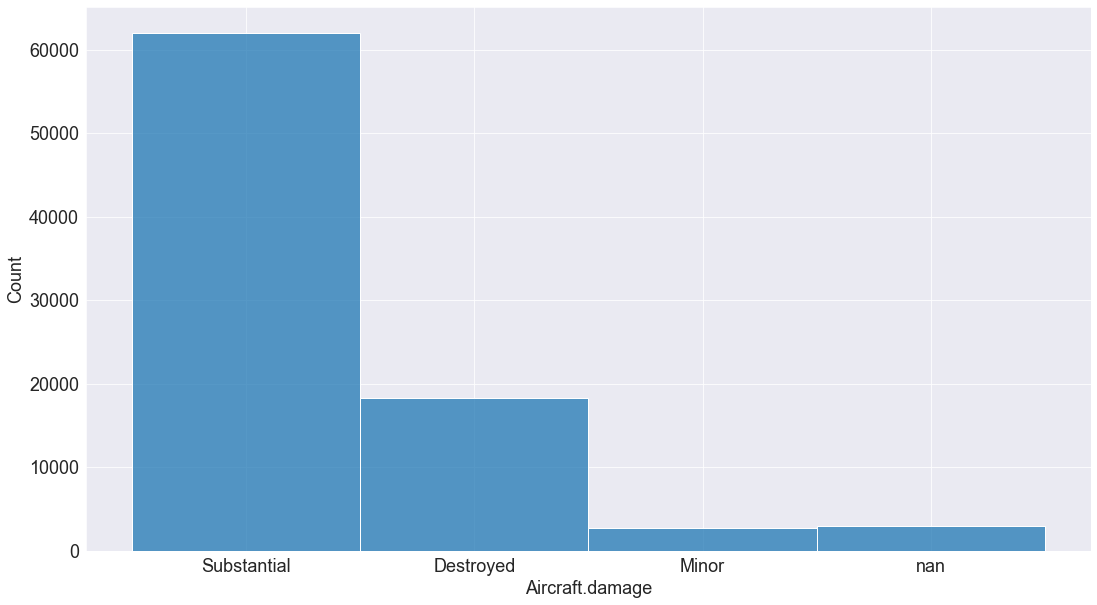

In [15]:
aviation_ds['Aircraft.damage'] =aviation_ds['Aircraft.damage'].astype(str)
sns.histplot(x = 'Aircraft.damage', data = aviation_ds);

Although the most common severity of injury is *non-fatal*, most of the events result in serious damages to aircraft.  
Let's see which aircraft categories are more affected by events:

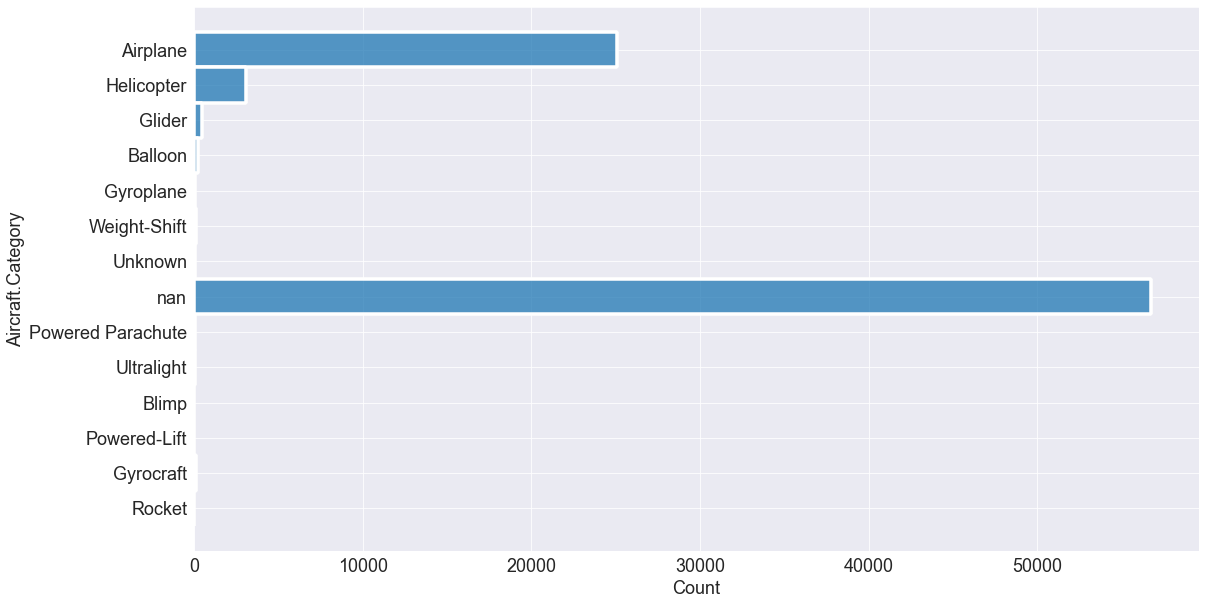

In [17]:
aviation_ds['Aircraft.Category'] = aviation_ds['Aircraft.Category'].astype(str)
sns.histplot(y = 'Aircraft.Category', data = aviation_ds);

Airplanes are more represented than other aircraft types. That being said, the misrepresented events **nan**  are more numerous than all other classes. This category has a lot of missing data.